# Exploratory Analysis
***

## Background

Determine the degree of consensus in contentious academic fields. 

Collect title, publication date and summaries from scholarly articles containing a certain keyword or keywords. Apply NLP models to this data to identify and categorise concepts in this field and determine statistical significance between opposing 'truths', if any. Ranking these groups according to weighted influence will prove the degree of consensus of various approaches in a given academic field.

To this end the academic_consensus model has already searched the abstracts of academic papers that contain the keyword "nutrition" and saved it into corpus_raw.csv.  
  
Overview of this notebook:
- Setup notebok environment and load data (corpus_raw.csv)
- Review articles published per year (sklearn's Countvectorizer)
- Create Bag Of Words (BOW) of all articles for Titles and Conclusions (nltk)
- Create interactive BOW per year with Bokeh

## Setup

### Packages and setup

In [76]:
# Common
import pandas as pd
import matplotlib.pyplot as plt
import nltk

# Complete BOW requirements
from collections import Counter
from collections import defaultdict
#from nltk.tokenize import word_tokenize
#from nltk.stem import WordNetLemmatizer
#from nltk.corpus import stopwords
from wordcloud import WordCloud, STOPWORDS

# Animated BOW over time
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer

# Workspace
from IPython.core.interactiveshell import InteractiveShell

In [77]:
# Bokeh
from bokeh.io import output_notebook, show, push_notebook
from bokeh.plotting import figure
from bokeh.models import ColumnDataSource, Slider
from ipywidgets import interact

In [78]:
# Set workspace
sns.set()
# Set output charackters to 110 (not 79)
pd.options.display.width = 110
# To give multiple cell output. Not just the last command.
InteractiveShell.ast_node_interactivity = 'last'

### Load and inspect corpus.csv

In [79]:
# Load corpus.csv as DataFrame with parsed date format
corpus = pd.read_csv('../data/interim/corpus_raw.csv', parse_dates=[0])#, index_col=0)

In [80]:
# Keyword 
keywords = ['nutrition', 'diet']

In [81]:
# Inspect
corpus.info()
corpus.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1530 entries, 0 to 1529
Data columns (total 3 columns):
publication_date    1530 non-null datetime64[ns, UTC]
title               1530 non-null object
conclusions         1530 non-null object
dtypes: datetime64[ns, UTC](1), object(2)
memory usage: 36.0+ KB


,publication_date,title,conclusions
0,2016-03-09 00:00:00+00:00,Pregnancy Requires Major Changes in the Qualit...,['Pregnancy tends to markedly widen the nutrit...
1,2016-08-23 00:00:00+00:00,Continental-Scale Patterns Reveal Potential fo...,"['In all, given the geographic patterns in die..."
2,2015-06-17 00:00:00+00:00,Assessing Nutritional Parameters of Brown Bear...,['Previous studies have illustrated the differ...
3,2015-04-17 00:00:00+00:00,The Self-Reported Clinical Practice Behaviors ...,['The present study provides a valuable insigh...
4,2017-10-09 00:00:00+00:00,The impact of nutritional supplement intake on...,['Our study shows that the propensity to consu...


## Articles published per year

### Functions

In [82]:
def print_docs_per_year(df):
    '''
    Plot bar chart of number of articles per year.
    df -> Dataframe
    '''
    df = df.set_index(['publication_date'])
    # Create a new dataframe with a temporary column
    df['###counter###'] = 1
    # Groupby year
    df = df.resample('Y').sum()
    # Extract year only from publication_date
    df['year_of_date'] = df.index
    df['year_of_date'] = pd.to_datetime(df['year_of_date']).dt.year
    # Reset index and select counter only
    article_year = df.set_index(['year_of_date'])['###counter###']
    
    # Bar plot
    plt.figure(figsize=(15,5))
    article_year.plot(kind='bar')
    plt.xticks(rotation=50);
    plt.xlabel('Year')
    plt.ylabel('Number of articles')
    plt.title('Number of articles containing keyword(s) "{}".'.format(', '.join(keywords)))

### Applications

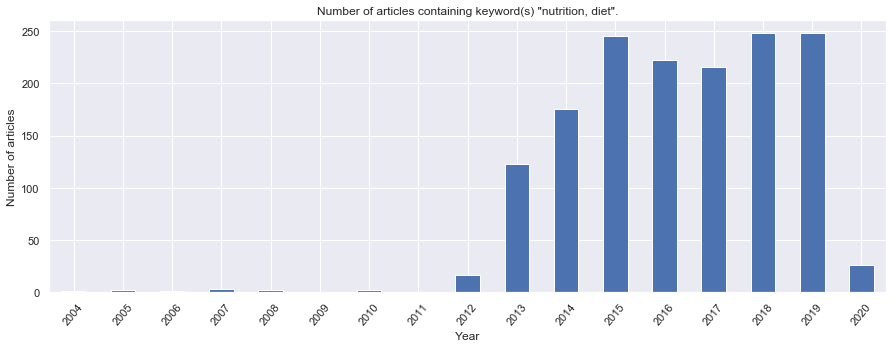

In [83]:
print_docs_per_year(corpus)

## Complete BOW for 'titles' and 'conclusions'

### Functions

In [84]:
def text_cleaning(row_text):
    ''' 
    Prepare row of text and convert to BOW
    Function to prepare text data: Tokenize, lowercase, minus numbers, 
    minus stopwords, lemmatised.
    '''
    tokens = word_tokenize(row_text)
    lower_tokens = [t.lower() for t in tokens]
    alpha_only = [t for t in lower_tokens if t.isalpha()]
    no_stops = [t for t in alpha_only if t not in stopwords.words('english')]
    noun_verb = [t for (t, pos) in nltk.pos_tag(no_stops) if (pos[:2] == 'NN')]# | (pos[:2] == 'VB')] NN
    
    wordnet_lemmatizer = WordNetLemmatizer()
    lemmatized = [wordnet_lemmatizer.lemmatize(t) for t in noun_verb]
    return lemmatized

In [85]:
def tokenise(df, col, show_progress=False):
    '''
    Convert to tokens given DataFrame and feature.
    '''
    # Select feature from DataFrame
    col_dict = dict(df[col])
    # Create a list of all tokens
    tokens_all =[]
    for key, row_text in col_dict.items():
        row_text_clean = text_cleaning(row_text)
        [tokens_all.append(word) for word in row_text_clean]
        if show_progress & (key % 100 == 0):
            print('Completed row {} of {}'.format(key, len(col_dict.items())), end='\r')
    
    return tokens_all

In [86]:
def bow_bar(df, col, num_words=30, show_progress=False):
    '''
    Plot bar chart of Bag Of Words for DataFrame feature.
    df -> DataFrame
    col -> Feature
    num_words -> Number of words to display in figure
    show_progress -> Show progress of tokenisation
    '''
    
    # Create tokens from df
    tokens_all = tokenise(df, col, show_progress)
    
    # Create Bag Of Words from all tokens
    bow = Counter(tokens_all)
    # Convert dictionary for ease of plotting
    bow_dict = dict(bow.most_common(num_words))
    # Plot
    plt.figure(figsize=(15,5))
    plt.bar(bow_dict.keys(), bow_dict.values())
    plt.xticks(rotation=50);
    plt.xlabel('Words appearing in {}'.format(col.title()))
    plt.ylabel('Word count')
    plt.title('Bag of Words for articles {} sections with keyword(s) "{}" with "{}" most apearing words.'
              .format(col.title(), ', '.join(keywords), num_words))
    

In [87]:
def bow_cloud(df, col, num_words=30, show_progress=False):
    '''
    Plot word cloud of Bag Of Words for DataFrame feature.
    df -> DataFrame
    col -> Feature
    num_words -> Number of words to display in figure
    show_progress -> Show progress of tokenisation
    '''
    
    # Create tokens from df
    tokens_all = tokenise(df, col, show_progress)
    
    # Create one continuous string of words to use 'wordcloud'
    tokens_all_str = ''
    for word in tokens_all:
        tokens_all_str += ' ' + word
    # add redundant stopwords
    stopwords_bow = set(STOPWORDS)
    #stopwords_bow.update(['effect', 'study'])
    wordcloud = WordCloud(background_color='white', stopwords=stopwords_bow).generate(tokens_all_str)
    # Display the generated image
    plt.figure(figsize=(20,5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.show()

### Applications

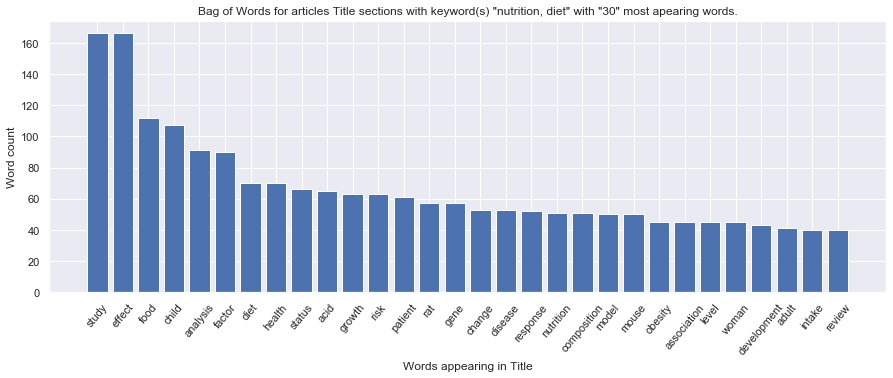

In [88]:
bow_bar(corpus, 'title', show_progress=True)

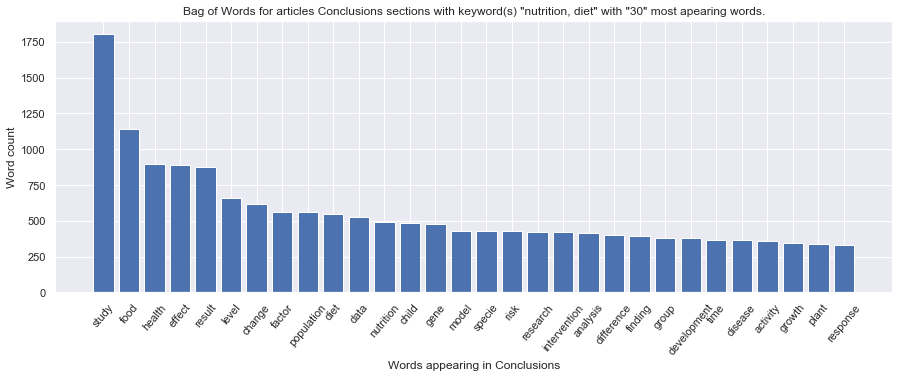

In [89]:
bow_bar(corpus, 'conclusions', show_progress=True)

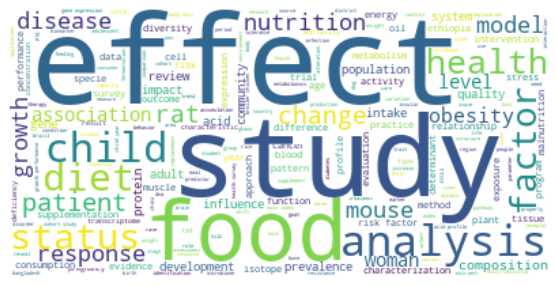

In [90]:
bow_cloud(corpus, 'title', show_progress=True)

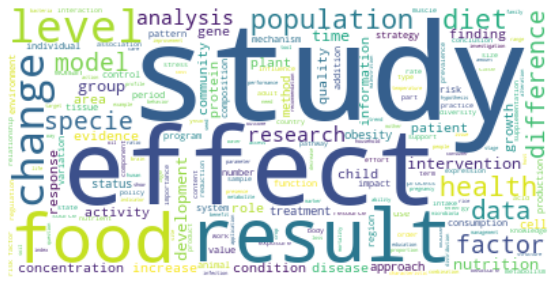

In [91]:
bow_cloud(corpus, 'conclusions', show_progress=True)

## Interactive BOW per year

### Functions

In [92]:
def bokeh_plot(df, col, top_n_words=25):
    '''
    Interactive plot of top n_words change over the years
    '''
    
    # Convert all feature's text to a list of documents
    docs = list(df[col])
    
    # Use CountVectorizer on all titles
    vect = CountVectorizer(stop_words='english', token_pattern='(?u)\\b\\w\\w+\\b')
    # Convert to document-term matrix
    docs_dtm = vect.fit_transform(docs)
    
    # Convert to dataframe
    df = pd.DataFrame(docs_dtm.toarray(), columns=vect.get_feature_names())
    # Add the published date column set it as index
    df['publication_date'] = corpus['publication_date']
    df = df.set_index(['publication_date'])
    
    # Order df from most occuring words to least
    # Group by year
    df = df.resample('Y').sum()
    # Get index of top 50 most occuring features
    index_most_features = df.resample('100Y').sum().iloc[1].sort_values(ascending=False).keys()
    # Convert to list
    index_most_features = list(index_most_features)
    # Re-order columns and select only top n words
    df = df[index_most_features[:top_n_words]]
    
    output_notebook()
    
    # Updating the plot from the slider
    def update_plot(year):
        dat.data_source.data['top'] = df[str(year)].values[0]
        push_notebook()
    
    # Bokeh plot for a given year
    # Initial conditions
    start_year = df.index.min().year
    end_year = df.index.max().year
    #val = start_year
    # Values
    words = list(df.columns)
    count = df[str(start_year)].values[0]
    year = start_year
    # Max y-value for y-axis
    max_y = df.max()[0] * 1.1
    
    # First plot
    pl = figure(x_range=words, plot_height=350, y_range=(0, max_y), 
                title='Word Count for "{}"'.format(col))
    dat = pl.vbar(x=words, top=count, width=0.9)
    pl.xgrid.grid_line_color = None
    pl.y_range.start = 0
    pl.xaxis.major_label_orientation = 3.14/4
    
    # Show plot with slider
    show(pl, notebook_handle=True)
    interact(update_plot, year=(start_year, end_year, 1));
    

### Applications

Note: you can only run one Bokeh figure at a time.

In [93]:
bokeh_plot(corpus, 'title')

Loading BokehJS ...

interactive(children=(IntSlider(value=2012, description='year', max=2020, min=2004), Output()), _dom_classes=(…

In [264]:
bokeh_plot(corpus, 'conclusions')

Loading BokehJS ...

interactive(children=(IntSlider(value=2012, description='year', max=2020, min=2004), Output()), _dom_classes=(…